In [215]:
##the packages we needed
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split

In [216]:
##create SQL connection
engine = create_engine('postgresql://postgres@localhost:5432/spatial')
df = pd.read_sql_query('select parcel.gcdistance, sales_analysis.price from volusia.parcel, volusia.sales_analysis where sales_analysis.parid = parcel.parid AND ST_Intersects(parcel.geom, ST_MakeEnvelope(541524,1695784,575191,1743390, 2236))',con=engine)
##location based on (541524,1695784,575191,1743390), which is the great Deland area
##or simply use deland.csv in my git
## df = pd.read_csv('your path\\deland.csv')

In [217]:
df.head()
##connection success

,gcdistance,price
0,1.441824,84000.0
1,1.118934,112000.0
2,0.615752,225000.0
3,0.332137,204600.0
4,0.332137,180000.0


In [218]:
df['gcdistance']

0       1.441824
1       1.118934
2       0.615752
3       0.332137
4       0.332137
          ...   
4897    0.266116
4898    0.272944
4899    0.281834
4900    0.281834
4901    0.444969
Name: gcdistance, Length: 4902, dtype: float64

In [219]:
##we want to remove the null values for the modeling purpose
df = df[df['gcdistance'].notna()]

In [220]:
##all good
df['gcdistance'].isnull().values.any()

False

In [221]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4771 entries, 0 to 4901
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   gcdistance  4771 non-null   float64
 1   price       4771 non-null   float64
dtypes: float64(2)
memory usage: 111.8 KB


<AxesSubplot:xlabel='gcdistance', ylabel='price'>

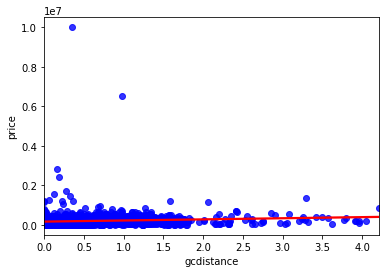

In [222]:
##intial distribution, outliers identified
dfx = df['gcdistance']
dfy = df['price']
sns.regplot(x=dfx,y=dfy,data=df, scatter_kws={"color": "blue"}, line_kws={"color": "red"}, fit_reg=True) 

In [223]:
##remove them
q_hi = df['price'].quantile(0.999)
q_low = df['price'].quantile(0.001)
df = df[(df['price']>q_low) & (df['price']<q_hi)]

<AxesSubplot:xlabel='gcdistance', ylabel='price'>

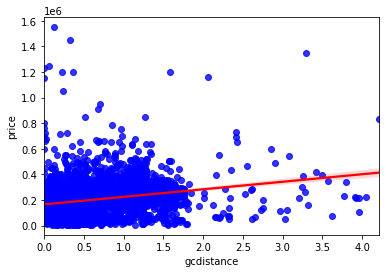

In [224]:
##a bit better, all we can see the trend is indicating further the distance higher the price
dfx = df['gcdistance']
dfy = df['price']
sns.regplot(x=dfx,y=dfy,data=df, scatter_kws={"color": "blue"}, line_kws={"color": "red"}, fit_reg=True) 

In [225]:
X = df[['gcdistance']]

In [226]:
y = df[['price']]

In [227]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                      test_size = 0.3, random_state = 666)

In [228]:
OLSmodel = sm.OLS(y_train, X_train).fit()
OLS_y_pred = OLSmodel.predict(X_test)

print_OLSmodel = OLSmodel.summary()
print(print_OLSmodel)

msq_pred = np.sqrt(mean_squared_error(y_test,OLS_y_pred))
r2_pred = r2_score(y_test, OLS_y_pred)

print('msq: ', msq_pred)
print('r2: ' , r2_pred)

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.573
Model:                            OLS   Adj. R-squared (uncentered):              0.573
Method:                 Least Squares   F-statistic:                              4477.
Date:                Fri, 30 Apr 2021   Prob (F-statistic):                        0.00
Time:                        16:33:46   Log-Likelihood:                         -44470.
No. Observations:                3332   AIC:                                  8.894e+04
Df Residuals:                    3331   BIC:                                  8.895e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------